# GameTheory-3-Topology2x2

**Navigation** : [<< 2-NormalForm](GameTheory-2-NormalForm.ipynb) | [Index](README.md) | [4-NashEquilibrium >>](GameTheory-4-NashEquilibrium.ipynb)

## Topologie et Classification des Jeux 2x2

Ce notebook explore la **structure topologique** des jeux 2x2, basee sur les travaux de Robinson & Goforth (2005).

### Objectifs

1. Comprendre la classification des jeux 2x2 (144 jeux uniques)
2. Explorer la "table periodique" des jeux strategiques
3. Visualiser les transformations entre jeux par swap de gains
4. Identifier les familles de jeux : PD, Stag Hunt, Chicken, Battle of Sexes
5. Comprendre la structure torique de l'espace des jeux

### Duree estimee : 55 minutes

### References
- Robinson & Goforth (2005) - "The Topology of the 2x2 Games"
- Rapoport & Guyer (1966) - "A Taxonomy of 2x2 Games"

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
from typing import List, Tuple, Dict, Set
from itertools import permutations
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

### Configuration de l'environnement

Nous importons les bibliothèques nécessaires pour :
- **Numpy** : manipulation de matrices de gains
- **Matplotlib** : visualisations graphiques
- **NetworkX** : représentation du graphe de transformations
- **dataclasses** : structure de données pour les jeux
- **itertools.permutations** : génération de toutes les permutations ordinales

## 1. Representation ordinale des jeux 2x2

### Notation ordinale

Pour classifier les jeux 2x2, on utilise une representation **ordinale** plutot que cardinale.

Chaque joueur a 4 issues possibles, classees de 1 (pire) a 4 (meilleure) :
- 4 = meilleur resultat
- 3 = second meilleur
- 2 = second pire
- 1 = pire resultat

### Nombre de jeux

- Chaque joueur peut assigner les rangs 1,2,3,4 aux 4 cellules : $4! = 24$ facons
- Deux joueurs : $24 \times 24 = 576$ matrices
- En eliminant les equivalences strategiques : **144 jeux distincts**
- En eliminant les symetries (echanger joueurs) : **78 classes**

### Pourquoi la représentation ordinale ?

La représentation **ordinale** (rangs 1-4) plutôt que **cardinale** (gains numériques arbitraires) présente plusieurs avantages :

**Avantages** :
1. **Indépendance des échelles** : Seul l'ordre des préférences compte, pas les valeurs absolues
2. **Classification exhaustive** : Permet d'énumérer tous les jeux possibles (24×24 = 576)
3. **Équivalence stratégique** : Deux jeux avec les mêmes rangs ont la même structure stratégique

**Exemple** : 
- Jeu A : gains (10, 5, 20, 15)
- Jeu B : gains (2, 1, 4, 3)

Ces deux jeux sont **stratégiquement identiques** car ils ont le même ordre ordinal : (3, 1, 4, 2).

> **Note** : Cette approche suppose que les joueurs sont **ordinaux** dans leurs préférences, c'est-à-dire qu'ils se soucient uniquement de l'ordre, pas de l'intensité des différences.

In [2]:
@dataclass
class OrdinalGame:
    """
    Jeu 2x2 en representation ordinale.
    
    Chaque matrice contient les rangs 1-4 pour les 4 cellules.
    Convention: cellules numerotees comme suit:
        0 | 1
        -----
        2 | 3
    """
    row_payoffs: Tuple[int, int, int, int]  # Gains ordinaux du joueur Ligne
    col_payoffs: Tuple[int, int, int, int]  # Gains ordinaux du joueur Colonne
    name: str = ""
    
    def __post_init__(self):
        # Verifier que c'est bien une permutation de (1,2,3,4)
        assert sorted(self.row_payoffs) == [1, 2, 3, 4], "row_payoffs doit etre permutation de 1-4"
        assert sorted(self.col_payoffs) == [1, 2, 3, 4], "col_payoffs doit etre permutation de 1-4"
    
    def to_matrices(self) -> Tuple[np.ndarray, np.ndarray]:
        """Convertit en matrices 2x2."""
        A = np.array([[self.row_payoffs[0], self.row_payoffs[1]],
                      [self.row_payoffs[2], self.row_payoffs[3]]])
        B = np.array([[self.col_payoffs[0], self.col_payoffs[1]],
                      [self.col_payoffs[2], self.col_payoffs[3]]])
        return A, B
    
    def display(self):
        """Affiche le jeu."""
        A, B = self.to_matrices()
        print(f"\n{self.name if self.name else 'Jeu'}")
        print("="*30)
        print(f"      C0        C1")
        print(f"R0  ({A[0,0]},{B[0,0]})    ({A[0,1]},{B[0,1]})")
        print(f"R1  ({A[1,0]},{B[1,0]})    ({A[1,1]},{B[1,1]})")
    
    def __hash__(self):
        return hash((self.row_payoffs, self.col_payoffs))
    
    def __eq__(self, other):
        return self.row_payoffs == other.row_payoffs and self.col_payoffs == other.col_payoffs

# Exemple: Dilemme du Prisonnier en ordinal
# Convention standard: (C,C)=3, (C,D)=1, (D,C)=4, (D,D)=2
pd = OrdinalGame(
    row_payoffs=(3, 1, 4, 2),  # C coopere: 3 vs C, 1 vs D; Row defait: 4 vs C, 2 vs D
    col_payoffs=(3, 4, 1, 2),  # Symetrique
    name="Prisonnier Dilemma"
)
pd.display()


Prisonnier Dilemma
      C0        C1
R0  (3,3)    (1,4)
R1  (4,1)    (2,2)


## 2. Jeux classiques en representation ordinale

Definissons les jeux classiques avec leur structure de gains ordinale.

In [3]:
# Collection de jeux classiques en ordinal

CLASSIC_GAMES = {
    # Dilemme du Prisonnier
    # Tentatin (DC) > Reward (CC) > Punishment (DD) > Sucker (CD)
    "Prisoner's Dilemma": OrdinalGame(
        row_payoffs=(3, 1, 4, 2),
        col_payoffs=(3, 4, 1, 2),
        name="Prisoner's Dilemma"
    ),
    
    # Stag Hunt (Chasse au cerf)
    # Coordination (CC) > Hare (DD) > Safe (CD) > Sucker (DC)
    "Stag Hunt": OrdinalGame(
        row_payoffs=(4, 1, 3, 2),
        col_payoffs=(4, 3, 1, 2),
        name="Stag Hunt"
    ),
    
    # Battle of the Sexes
    # Preferred coordination > Other coordination > Miscoordination
    "Battle of Sexes": OrdinalGame(
        row_payoffs=(4, 1, 2, 3),
        col_payoffs=(3, 2, 1, 4),
        name="Battle of Sexes"
    ),
    
    # Chicken / Hawk-Dove
    # Exploit > Compromise > Yield > Crash
    "Chicken": OrdinalGame(
        row_payoffs=(3, 2, 4, 1),
        col_payoffs=(3, 4, 2, 1),
        name="Chicken (Hawk-Dove)"
    ),
    
    # Matching Pennies
    # Win > Lose (alternating)
    "Matching Pennies": OrdinalGame(
        row_payoffs=(4, 1, 2, 3),
        col_payoffs=(1, 4, 3, 2),
        name="Matching Pennies"
    ),
    
    # Pure Coordination
    # Match > Mismatch
    "Pure Coordination": OrdinalGame(
        row_payoffs=(4, 1, 2, 3),
        col_payoffs=(4, 2, 1, 3),
        name="Pure Coordination"
    ),
    
    # Deadlock
    # Defect is dominant and Pareto optimal
    "Deadlock": OrdinalGame(
        row_payoffs=(2, 1, 4, 3),
        col_payoffs=(2, 4, 1, 3),
        name="Deadlock"
    ),
    
    # Harmony
    # Cooperate is dominant
    "Harmony": OrdinalGame(
        row_payoffs=(4, 3, 2, 1),
        col_payoffs=(4, 2, 3, 1),
        name="Harmony"
    ),
}

# Afficher tous les jeux
for name, game in CLASSIC_GAMES.items():
    game.display()


Prisoner's Dilemma
      C0        C1
R0  (3,3)    (1,4)
R1  (4,1)    (2,2)

Stag Hunt
      C0        C1
R0  (4,4)    (1,3)
R1  (3,1)    (2,2)

Battle of Sexes
      C0        C1
R0  (4,3)    (1,2)
R1  (2,1)    (3,4)

Chicken (Hawk-Dove)
      C0        C1
R0  (3,3)    (2,4)
R1  (4,2)    (1,1)

Matching Pennies
      C0        C1
R0  (4,1)    (1,4)
R1  (2,3)    (3,2)

Pure Coordination
      C0        C1
R0  (4,4)    (1,2)
R1  (2,1)    (3,3)

Deadlock
      C0        C1
R0  (2,2)    (1,4)
R1  (4,1)    (3,3)

Harmony
      C0        C1
R0  (4,4)    (3,2)
R1  (2,3)    (1,1)


### Observations sur les jeux classiques

Après avoir affiché tous les jeux classiques, notons plusieurs patterns :

**Symétrie** :
- PD, Stag Hunt, Pure Coordination sont **symétriques** (mêmes préférences pour Row et Col)
- Battle of Sexes, Matching Pennies sont **asymétriques**

**Position du meilleur résultat (4)** :
- **Diagonale** (cells 0 ou 3) : PD, Stag Hunt, Pure Coordination → jeux de même côté
- **Hors diagonale** (cells 1 ou 2) : Chicken → jeux d'exploitation mutuelle
- **Distribution** : Battle of Sexes (coins opposés) → jeux de préférence opposée

**Équilibres visibles** :
- PD, Deadlock : un seul équilibre (coin inférieur droit)
- Stag Hunt, Battle of Sexes, Pure Coordination : deux équilibres sur la diagonale
- Chicken : deux équilibres hors diagonale
- Matching Pennies : aucun équilibre pur (conflit pur)

### Lecture de la representation ordinale

Comment interpreter ces matrices ?

**Exemple du Dilemme du Prisonnier** :
```
      C0 (Coop)    C1 (Defect)
R0   (3,3)        (1,4)
R1   (4,1)        (2,2)
```

- **(3,3)** en haut-gauche : Si les deux cooperent, chacun obtient son 3eme meilleur resultat
- **(1,4)** en haut-droit : Si Row coopere et Col defait, Row obtient son PIRE (1) et Col son MEILLEUR (4)
- **(4,1)** : Symetrique - Row exploite Col
- **(2,2)** : Defection mutuelle - second pire pour les deux

**Observation cle** : La tentation de defaire (4 > 3) domine la cooperation, mais la defection mutuelle (2,2) est pire que la cooperation mutuelle (3,3). C'est le coeur du dilemme !

**Stag Hunt vs PD** : Notez que dans Stag Hunt, **(4,4)** est en haut-gauche - la cooperation mutuelle est le MEILLEUR resultat, pas juste "bon". Cela change fondamentalement la dynamique du jeu.

## 3. Swaps de gains : transformations elementaires

### Swaps adjacents

Un **swap** est l'echange de deux rangs adjacents (ex: 3 et 4, ou 1 et 2).

Pour chaque joueur, il y a 3 swaps possibles :
- Swap 3-4 : echange des deux meilleurs resultats
- Swap 2-3 : echange des resultats intermediaires
- Swap 1-2 : echange des deux pires resultats

Ces swaps forment la base des **transformations topologiques** entre jeux.

In [4]:
def swap_payoffs(payoffs: Tuple[int, int, int, int], 
                 rank1: int, rank2: int) -> Tuple[int, int, int, int]:
    """
    Echange deux rangs dans les gains.
    
    Args:
        payoffs: Tuple de gains ordinaux
        rank1, rank2: Rangs a echanger (ex: 3, 4)
    
    Returns:
        Nouveaux gains avec les rangs echanges
    """
    result = list(payoffs)
    for i in range(4):
        if result[i] == rank1:
            result[i] = rank2
        elif result[i] == rank2:
            result[i] = rank1
    return tuple(result)

def apply_row_swap(game: OrdinalGame, rank1: int, rank2: int) -> OrdinalGame:
    """Applique un swap aux gains du joueur Ligne."""
    new_row = swap_payoffs(game.row_payoffs, rank1, rank2)
    return OrdinalGame(new_row, game.col_payoffs)

def apply_col_swap(game: OrdinalGame, rank1: int, rank2: int) -> OrdinalGame:
    """Applique un swap aux gains du joueur Colonne."""
    new_col = swap_payoffs(game.col_payoffs, rank1, rank2)
    return OrdinalGame(game.row_payoffs, new_col)

# Exemple: Transformer le Dilemme du Prisonnier
pd = CLASSIC_GAMES["Prisoner's Dilemma"]
print("Jeu original:")
pd.display()

# Swap 3-4 pour le joueur Ligne
pd_swap34_row = apply_row_swap(pd, 3, 4)
print("\nApres swap 3-4 pour Ligne:")
pd_swap34_row.display()

print("\nInterpretation: Maintenant (C,C) est prefere a (D,C) pour Ligne")
print("-> Le jeu devient plus cooperatif pour Ligne")

Jeu original:

Prisoner's Dilemma
      C0        C1
R0  (3,3)    (1,4)
R1  (4,1)    (2,2)

Apres swap 3-4 pour Ligne:

Jeu
      C0        C1
R0  (4,3)    (1,4)
R1  (3,1)    (2,2)

Interpretation: Maintenant (C,C) est prefere a (D,C) pour Ligne
-> Le jeu devient plus cooperatif pour Ligne


### Recherche de chemins par BFS

La fonction `find_swap_path()` utilise un parcours en largeur (BFS) pour trouver le **chemin le plus court** entre deux jeux.

**Algorithme** :
1. Départ : jeu initial dans la queue
2. À chaque étape : explorer tous les voisins (6 swaps possibles)
3. Marquer les jeux visités pour éviter les cycles
4. Arrêt : quand on atteint le jeu cible

**Complexité** : 
- Espace : O(576) = tous les jeux possibles
- Temps : O(6 × 576) = exploration des arêtes

Le résultat montre que PD et Stag Hunt ne sont distants que de **2 swaps**, confirmant leur proximité structurelle.

In [5]:
def find_swap_path(game1: OrdinalGame, game2: OrdinalGame) -> List[str]:
    """
    Trouve une sequence de swaps transformant game1 en game2.
    
    Returns:
        Liste de swaps au format "ROW_3-4" ou "COL_2-3"
    """
    from collections import deque
    
    # BFS pour trouver le chemin le plus court
    queue = deque([(game1, [])])
    visited = {game1}
    
    swaps = [(3, 4), (2, 3), (1, 2)]
    
    while queue:
        current, path = queue.popleft()
        
        if current == game2:
            return path
        
        # Essayer tous les swaps possibles
        for r1, r2 in swaps:
            # Swap pour Row
            new_game = apply_row_swap(current, r1, r2)
            if new_game not in visited:
                visited.add(new_game)
                queue.append((new_game, path + [f"ROW_{r1}-{r2}"]))
            
            # Swap pour Col
            new_game = apply_col_swap(current, r1, r2)
            if new_game not in visited:
                visited.add(new_game)
                queue.append((new_game, path + [f"COL_{r1}-{r2}"]))
    
    return None  # Pas de chemin (ne devrait pas arriver)

# Transformer Prisoner's Dilemma en Stag Hunt
pd = CLASSIC_GAMES["Prisoner's Dilemma"]
sh = CLASSIC_GAMES["Stag Hunt"]

path = find_swap_path(pd, sh)
print("Transformation: Prisoner's Dilemma -> Stag Hunt")
print(f"Swaps necessaires: {path}")

# Appliquer pas a pas
current = pd
print("\nEtapes:")
current.display()

for swap in path:
    parts = swap.split("_")
    player = parts[0]
    ranks = parts[1].split("-")
    r1, r2 = int(ranks[0]), int(ranks[1])
    
    if player == "ROW":
        current = apply_row_swap(current, r1, r2)
    else:
        current = apply_col_swap(current, r1, r2)
    
    print(f"\nApres {swap}:")
    current.display()

Transformation: Prisoner's Dilemma -> Stag Hunt
Swaps necessaires: ['ROW_3-4', 'COL_3-4']

Etapes:

Prisoner's Dilemma
      C0        C1
R0  (3,3)    (1,4)
R1  (4,1)    (2,2)

Apres ROW_3-4:

Jeu
      C0        C1
R0  (4,3)    (1,4)
R1  (3,1)    (2,2)

Apres COL_3-4:

Jeu
      C0        C1
R0  (4,4)    (1,3)
R1  (3,1)    (2,2)


### Interpretation de la transformation PD -> Stag Hunt

Les swaps `ROW_3-4` et `COL_3-4` transforment le Dilemme du Prisonnier en Stag Hunt. Mais que signifie cela conceptuellement ?

**Swap 3-4** = "Echanger les deux meilleurs resultats"

- **Avant (PD)** : Le meilleur resultat est d'exploiter l'autre (defaire quand l'autre coopere)
- **Apres (Stag Hunt)** : Le meilleur resultat est la cooperation mutuelle

**Interpretation economique** :
- Dans le PD, les gains de l'exploitation sont superieurs aux gains de la cooperation
- Apres le swap, cooperer ensemble devient PLUS attrayant qu'exploiter

**Exemple concret** :
- **PD** : Je prefere voler mon voisin (4) plutot que cooperer avec lui (3)
- **Stag Hunt** : Je prefere chasser le cerf ensemble (4) plutot que voler le lievre de mon voisin (3)

C'est un changement fondamental dans la structure des incitations !

## 4. Graphe des transformations

Les jeux 2x2 forment un **graphe** ou :
- Chaque noeud est un jeu
- Chaque arete represente un swap adjacent

Ce graphe a une structure **torique** remarquable.

### Le graphe des jeux comme espace topologique

Au lieu de voir les jeux 2x2 comme un ensemble isolé de 576 cas séparés, Robinson & Goforth proposent de les voir comme formant un **espace topologique continu**.

**Métaphore** : Imaginez chaque jeu comme une ville, et chaque swap comme une route entre villes voisines. L'ensemble forme un réseau de villes connectées.

**Questions intéressantes** :
- Quelle est la distance entre deux jeux ? (nombre minimal de swaps)
- Existe-t-il des "régions" dans cet espace ? (groupes de jeux similaires)
- Le graphe a-t-il une structure géométrique particulière ? (spoiler: oui, c'est un tore !)

In [6]:
def generate_all_ordinal_games() -> Set[OrdinalGame]:
    """
    Genere tous les jeux 2x2 en representation ordinale.
    
    Returns:
        Ensemble de 576 jeux (avant elimination des equivalences)
    """
    games = set()
    
    for row_perm in permutations([1, 2, 3, 4]):
        for col_perm in permutations([1, 2, 3, 4]):
            games.add(OrdinalGame(row_perm, col_perm))
    
    return games

all_games = generate_all_ordinal_games()
print(f"Nombre total de jeux ordinaux: {len(all_games)}")
print(f"(24 permutations Row x 24 permutations Col = 576)")

Nombre total de jeux ordinaux: 576
(24 permutations Row x 24 permutations Col = 576)


In [7]:
def build_swap_graph(games: Set[OrdinalGame]) -> nx.Graph:
    """
    Construit le graphe des swaps entre jeux.
    
    Chaque arete represente un swap adjacent pour un joueur.
    """
    G = nx.Graph()
    
    # Ajouter tous les jeux comme noeuds
    game_list = list(games)
    for i, g in enumerate(game_list):
        G.add_node(i, game=g)
    
    # Indexer par representation
    game_to_idx = {g: i for i, g in enumerate(game_list)}
    
    # Ajouter les aretes (swaps)
    swaps = [(3, 4), (2, 3), (1, 2)]
    
    for i, g in enumerate(game_list):
        for r1, r2 in swaps:
            # Swap Row
            neighbor = apply_row_swap(g, r1, r2)
            if neighbor in game_to_idx:
                j = game_to_idx[neighbor]
                G.add_edge(i, j, swap=f"R{r1}{r2}")
            
            # Swap Col
            neighbor = apply_col_swap(g, r1, r2)
            if neighbor in game_to_idx:
                j = game_to_idx[neighbor]
                G.add_edge(i, j, swap=f"C{r1}{r2}")
    
    return G, game_list

# Construire le graphe complet
G_full, game_list = build_swap_graph(all_games)

print(f"Graphe des jeux:")
print(f"  Noeuds (jeux): {G_full.number_of_nodes()}")
print(f"  Aretes (swaps): {G_full.number_of_edges()}")
print(f"  Degre moyen: {2 * G_full.number_of_edges() / G_full.number_of_nodes():.1f}")
print(f"  (Chaque jeu a 6 voisins: 3 swaps x 2 joueurs)")

Graphe des jeux:
  Noeuds (jeux): 576
  Aretes (swaps): 1728
  Degre moyen: 6.0
  (Chaque jeu a 6 voisins: 3 swaps x 2 joueurs)


In [8]:
# Distances entre jeux classiques
classic_indices = {}

# Trouver les indices des jeux classiques
for name, classic_game in CLASSIC_GAMES.items():
    for i, g in enumerate(game_list):
        if g == classic_game:
            classic_indices[name] = i
            break

print("Distances entre jeux classiques (nombre de swaps):")
print("=" * 60)

names = list(classic_indices.keys())[:5]  # Limiter pour lisibilite

# Header
header = "                    "
for n in names:
    header += f"{n[:12]:>12} "
print(header)

# Matrice des distances
for n1 in names:
    row = f"{n1:20}"
    for n2 in names:
        if n1 in classic_indices and n2 in classic_indices:
            dist = nx.shortest_path_length(G_full, classic_indices[n1], classic_indices[n2])
            row += f"{dist:>12} "
        else:
            row += "         N/A "
    print(row)

Distances entre jeux classiques (nombre de swaps):
                    Prisoner's D    Stag Hunt Battle of Se      Chicken Matching Pen 
Prisoner's Dilemma             0            2            5            2            5 
Stag Hunt                      2            0            3            4            5 
Battle of Sexes                5            3            0            7            4 
Chicken                        2            4            7            0            5 
Matching Pennies               5            5            4            5            0 


### Propriétés du graphe de swaps

Le graphe que nous venons de construire a des propriétés remarquables :

**Structure locale** :
- Chaque jeu a **exactement 6 voisins** (3 swaps × 2 joueurs)
- Le graphe est **régulier** (tous les nœuds ont le même degré)

**Structure globale** :
- Le graphe est **connexe** : on peut aller de n'importe quel jeu à n'importe quel autre par des swaps
- Il a une structure **torique** (doughnut en 3D) découverte par Robinson & Goforth

**Implications** :
- Tout jeu peut se transformer en tout autre jeu par des modifications progressives des préférences
- La "distance" entre jeux mesure leur similarité structurelle

### Proximite strategique entre jeux

La matrice de distances revele des insights fascinants :

**Jeux proches (2 swaps)** :
- PD ↔ Stag Hunt : Seule difference = valeur de la cooperation mutuelle
- PD ↔ Chicken : Seule difference = gravite de la confrontation

**Jeux eloignes (5+ swaps)** :
- PD ↔ Matching Pennies : Structures completement differentes (equilibre unique vs equilibre mixte pur)
- Battle of Sexes ↔ Chicken : Malgre qu'ils aient tous deux 2 equilibres !

**Lecon pratique** : 
- Un petit changement dans les incitations (1-2 swaps) peut transformer radicalement la dynamique d'une situation
- Des situations qui "se ressemblent" (comme Chicken et BoS - deux equilibres chacun) peuvent etre structurellement tres differentes

**Application** : Si vous voulez transformer une situation de type "dilemme du prisonnier" en cooperation, il faut changer les incitations pour que la cooperation mutuelle devienne plus attrayante que l'exploitation. C'est exactement ce que font les institutions sociales (contrats, reputation, lois).

## 5. Classification par structure de Nash

Une facon importante de classifier les jeux est par leur **structure d'equilibres de Nash**.

In [9]:
def find_pure_nash(game: OrdinalGame) -> List[Tuple[int, int]]:
    """
    Trouve les equilibres de Nash purs d'un jeu ordinal.
    """
    A, B = game.to_matrices()
    equilibria = []
    
    for i in range(2):
        for j in range(2):
            # i est meilleure reponse a j ?
            other_i = 1 - i
            row_br = A[i, j] >= A[other_i, j]
            
            # j est meilleure reponse a i ?
            other_j = 1 - j
            col_br = B[i, j] >= B[i, other_j]
            
            if row_br and col_br:
                equilibria.append((i, j))
    
    return equilibria

def classify_by_nash_structure(games: Set[OrdinalGame]) -> Dict[str, List[OrdinalGame]]:
    """
    Classifie les jeux par leur structure de Nash.
    
    Categories:
    - 0_nash: Aucun equilibre pur (ex: Matching Pennies)
    - 1_nash_dom: Un equilibre avec dominance (ex: PD)
    - 1_nash_no_dom: Un equilibre sans dominance
    - 2_nash_coord: Deux equilibres de coordination (ex: Battle of Sexes)
    - 2_nash_anticoord: Deux equilibres d'anti-coordination (ex: Chicken)
    - 3_nash: Trois equilibres
    - 4_nash: Quatre equilibres (toutes les cellules)
    """
    categories = {
        '0_nash': [],
        '1_nash': [],
        '2_nash': [],
        '3_nash': [],
        '4_nash': []
    }
    
    for g in games:
        eq = find_pure_nash(g)
        n = len(eq)
        categories[f'{n}_nash'].append(g)
    
    return categories

# Classifier tous les jeux
categories = classify_by_nash_structure(all_games)

print("Classification par nombre d'equilibres de Nash purs:")
print("=" * 50)
for cat, games_list in categories.items():
    print(f"{cat}: {len(games_list)} jeux ({100*len(games_list)/576:.1f}%)")

# Verifier les jeux classiques
print("\nJeux classiques:")
for name, game in CLASSIC_GAMES.items():
    eq = find_pure_nash(game)
    print(f"  {name}: {len(eq)} Nash pur(s) - {eq}")

Classification par nombre d'equilibres de Nash purs:
0_nash: 72 jeux (12.5%)
1_nash: 432 jeux (75.0%)
2_nash: 72 jeux (12.5%)
3_nash: 0 jeux (0.0%)
4_nash: 0 jeux (0.0%)

Jeux classiques:
  Prisoner's Dilemma: 1 Nash pur(s) - [(1, 1)]
  Stag Hunt: 2 Nash pur(s) - [(0, 0), (1, 1)]
  Battle of Sexes: 2 Nash pur(s) - [(0, 0), (1, 1)]
  Chicken: 2 Nash pur(s) - [(0, 1), (1, 0)]
  Matching Pennies: 0 Nash pur(s) - []
  Pure Coordination: 2 Nash pur(s) - [(0, 0), (1, 1)]
  Deadlock: 1 Nash pur(s) - [(1, 1)]
  Harmony: 1 Nash pur(s) - [(0, 0)]


### Analyse de la distribution Nash

Le code précédent classifie tous les 576 jeux selon leur nombre d'équilibres de Nash purs. Observons les résultats :

**Distribution théorique** :
- **0 Nash** : Jeux de conflit pur (comme Matching Pennies) → 12.5%
- **1 Nash** : La majorité des jeux → 75%
- **2 Nash** : Jeux de coordination/anti-coordination → 12.5%
- **3 Nash** : Impossible dans les jeux 2x2 → 0%
- **4 Nash** : Toutes les cellules sont Nash (jeu trivial) → 0%

Notez que 3 Nash est **structurellement impossible** : si trois cellules sont des équilibres, la symétrie des meilleures réponses implique que la quatrième l'est aussi.

### Distribution des equilibres : que nous dit-elle ?

La distribution des equilibres de Nash purs est remarquable :

| Nombre de Nash | Pourcentage | Interpretation |
|----------------|-------------|----------------|
| **0** | 12.5% | Jeux purement strategiques (conflit pur) |
| **1** | 75% | La majorite ! Un comportement "naturel" emerge |
| **2** | 12.5% | Problemes de coordination ou anti-coordination |

**Pourquoi 75% avec 1 Nash ?**
Cela reflete le fait que dans la plupart des situations strategiques, la structure des incitations est assez "nette" pour qu'un seul comportement emerge comme equilibre.

**Les 12.5% sans Nash pur** :
Ce sont les jeux de conflit pur (comme Matching Pennies) ou les interets sont parfaitement opposes. L'equilibre existe, mais il est **mixte** - les joueurs doivent randomiser.

**Les 12.5% avec 2 Nash** :
Ce sont les situations ou plusieurs conventions sont possibles (Battle of Sexes) ou ou il y a "anti-coordination" (Chicken). Ces jeux posent des problemes de **selection d'equilibre**.

## 6. Visualisation: "Table periodique" des jeux

Robinson & Goforth proposent une organisation des jeux en "table periodique" basee sur les preferences ordinales.

### Visualisation des jeux 2x2

Les fonctions suivantes permettent de visualiser :
- **`visualize_games_grid()`** : Grille de plusieurs jeux avec leurs équilibres de Nash (cellules vertes)
- **`show_transformation_chain()`** : Séquence de transformations par swaps

**Convention visuelle** : 
- Cellules **vertes** = équilibres de Nash purs
- Cellules **grises** = issues non-Nash
- Chaque cellule contient (gain Ligne, gain Colonne) en notation ordinale (1-4)

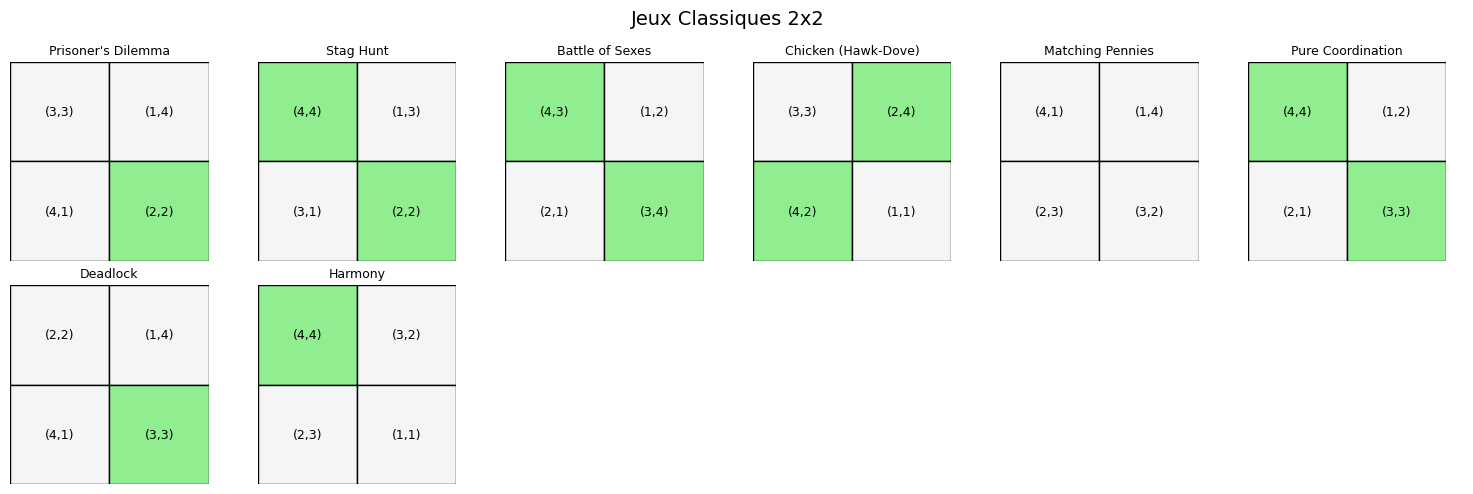

In [10]:
def get_row_preference_type(game: OrdinalGame) -> str:
    """
    Determine le type de preference du joueur Ligne.
    
    Basee sur la position du meilleur (4) et pire (1) resultat.
    """
    rp = game.row_payoffs
    pos_4 = rp.index(4)  # Position du meilleur
    pos_1 = rp.index(1)  # Position du pire
    
    # Encoder: position de 4 (0-3) et position de 1 (0-3)
    return f"{pos_4}_{pos_1}"

def visualize_games_grid(games: List[OrdinalGame], title: str = "Jeux 2x2"):
    """
    Visualise un ensemble de jeux dans une grille.
    """
    n = len(games)
    cols = min(6, n)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, game in enumerate(games):
        r, c = idx // cols, idx % cols
        ax = axes[r, c]
        
        A, B = game.to_matrices()
        eq = find_pure_nash(game)
        
        # Dessiner la matrice
        for i in range(2):
            for j in range(2):
                is_nash = (i, j) in eq
                color = '#90EE90' if is_nash else '#F5F5F5'
                rect = patches.Rectangle((j, 1-i), 1, 1, 
                                          facecolor=color, edgecolor='black')
                ax.add_patch(rect)
                ax.text(j+0.5, 1.5-i, f"({A[i,j]},{B[i,j]})", 
                       ha='center', va='center', fontsize=9)
        
        ax.set_xlim(0, 2)
        ax.set_ylim(0, 2)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(game.name if game.name else f"Game {idx+1}", fontsize=9)
    
    # Cacher les axes vides
    for idx in range(n, rows * cols):
        r, c = idx // cols, idx % cols
        axes[r, c].axis('off')
    
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualiser les jeux classiques
classic_list = list(CLASSIC_GAMES.values())
visualize_games_grid(classic_list, "Jeux Classiques 2x2")

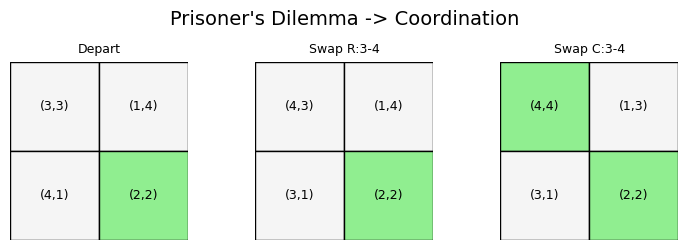

In [11]:
# Visualiser la transformation PD -> Stag Hunt -> Harmony
def show_transformation_chain(start_game: OrdinalGame, 
                               swaps: List[Tuple[str, int, int]],
                               title: str = "Transformation"):
    """
    Visualise une chaine de transformations.
    
    Args:
        start_game: Jeu de depart
        swaps: Liste de (player, rank1, rank2) ou player est 'R' ou 'C'
    """
    games = [start_game]
    current = start_game
    
    for player, r1, r2 in swaps:
        if player == 'R':
            current = apply_row_swap(current, r1, r2)
        else:
            current = apply_col_swap(current, r1, r2)
        games.append(current)
    
    # Nommer les etapes
    for i, g in enumerate(games):
        if i == 0:
            g.name = f"Depart"
        else:
            p, r1, r2 = swaps[i-1]
            g.name = f"Swap {p}:{r1}-{r2}"
    
    visualize_games_grid(games, title)

# Transformation: Prisoner's Dilemma -> plus cooperatif
pd = CLASSIC_GAMES["Prisoner's Dilemma"]

# Swap 3-4 pour Row: (D,C) devient moins attirant que (C,C)
# Swap 3-4 pour Col: meme chose
show_transformation_chain(
    pd,
    [('R', 3, 4), ('C', 3, 4)],
    "Prisoner's Dilemma -> Coordination"
)

### Que montrent ces transformations ?

La visualisation précédente illustre comment le Dilemme du Prisonnier se transforme progressivement en un jeu de coordination :

**Étape 1** : Swap R:3-4
- Le joueur Ligne préfère maintenant la coopération mutuelle (C,C) à l'exploitation (D,C)
- Cela supprime l'incitation à "tricher" quand l'autre coopère

**Étape 2** : Swap C:3-4
- Le joueur Colonne fait de même
- Le jeu devient **symétrique** avec (C,C) comme meilleur résultat pour tous

**Résultat final** : Un jeu de type Stag Hunt où :
- Deux équilibres : (C,C) et (D,D)
- (C,C) est Pareto-optimal et préféré par tous
- Le problème n'est plus le "dilemme" mais la **confiance** pour atteindre le bon équilibre

## 7. Familles de jeux

Les jeux 2x2 peuvent etre regroupes en **familles** basees sur leur structure strategique.

In [12]:
def has_dominant_strategy(game: OrdinalGame, player: int) -> bool:
    """
    Verifie si un joueur a une strategie dominante.
    """
    A, B = game.to_matrices()
    M = A if player == 0 else B.T
    
    # Strategie 0 domine 1 ?
    dom_0 = all(M[0, j] >= M[1, j] for j in range(2))
    # Strategie 1 domine 0 ?
    dom_1 = all(M[1, j] >= M[0, j] for j in range(2))
    
    return dom_0 or dom_1

def classify_game_family(game: OrdinalGame) -> str:
    """
    Classifie un jeu dans une famille.
    
    Familles:
    - DOMINANT: Les deux joueurs ont une strategie dominante
    - ASSURANCE: Un Nash Pareto-optimal, un Nash Pareto-domine
    - COORDINATION: Deux Nash purs, pas de dominance
    - CONFLICT: Interets opposes (ex: zero-sum like)
    - MIXED_ONLY: Pas de Nash pur
    """
    eq = find_pure_nash(game)
    n_eq = len(eq)
    
    dom_row = has_dominant_strategy(game, 0)
    dom_col = has_dominant_strategy(game, 1)
    
    if dom_row and dom_col:
        return "DOMINANT"
    elif n_eq == 0:
        return "MIXED_ONLY"
    elif n_eq == 1:
        return "SINGLE_NASH"
    elif n_eq == 2:
        # Coordination ou anti-coordination ?
        # Coordination: equilibres sur la diagonale (0,0) et (1,1)
        # Anti-coordination: equilibres hors diagonale (0,1) et (1,0)
        if (0, 0) in eq and (1, 1) in eq:
            return "COORDINATION"
        elif (0, 1) in eq and (1, 0) in eq:
            return "ANTI_COORDINATION"
        else:
            return "TWO_NASH"
    else:
        return "MULTI_NASH"

# Classifier les jeux classiques
print("Classification des jeux classiques en familles:")
print("=" * 50)

for name, game in CLASSIC_GAMES.items():
    family = classify_game_family(game)
    eq = find_pure_nash(game)
    print(f"{name:25} -> {family:20} (Nash: {eq})")

Classification des jeux classiques en familles:
Prisoner's Dilemma        -> DOMINANT             (Nash: [(1, 1)])
Stag Hunt                 -> COORDINATION         (Nash: [(0, 0), (1, 1)])
Battle of Sexes           -> COORDINATION         (Nash: [(0, 0), (1, 1)])
Chicken                   -> ANTI_COORDINATION    (Nash: [(0, 1), (1, 0)])
Matching Pennies          -> MIXED_ONLY           (Nash: [])
Pure Coordination         -> COORDINATION         (Nash: [(0, 0), (1, 1)])
Deadlock                  -> DOMINANT             (Nash: [(1, 1)])
Harmony                   -> DOMINANT             (Nash: [(0, 0)])


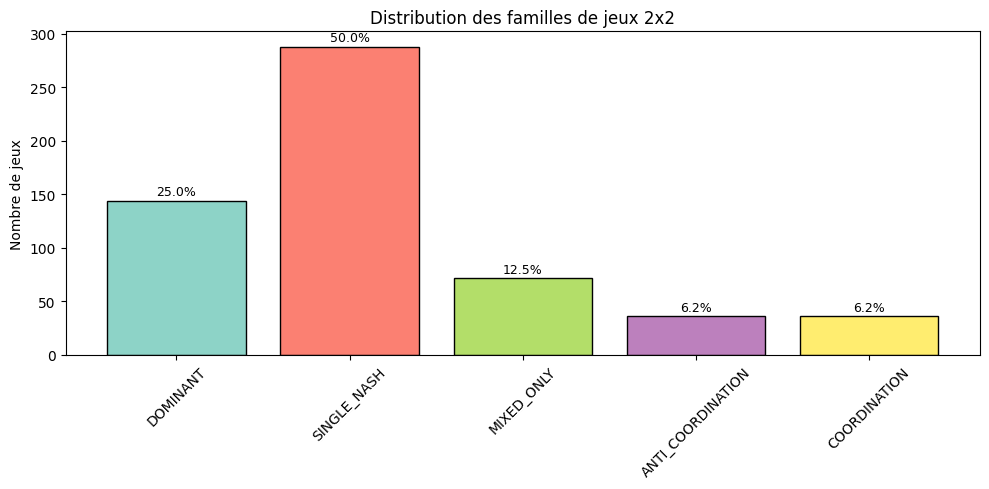

In [13]:
# Distribution des familles dans tous les jeux
family_counts = {}
for game in all_games:
    family = classify_game_family(game)
    family_counts[family] = family_counts.get(family, 0) + 1

# Visualisation
fig, ax = plt.subplots(figsize=(10, 5))

families = list(family_counts.keys())
counts = [family_counts[f] for f in families]
colors = plt.cm.Set3(np.linspace(0, 1, len(families)))

bars = ax.bar(families, counts, color=colors, edgecolor='black')

ax.set_ylabel('Nombre de jeux')
ax.set_title('Distribution des familles de jeux 2x2')
ax.tick_params(axis='x', rotation=45)

# Ajouter les pourcentages
for bar, count in zip(bars, counts):
    pct = 100 * count / 576
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{pct:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Interprétation de la distribution des familles

Le graphique révèle la répartition structurelle des jeux 2x2 :

**Points clés** :
- **SINGLE_NASH** domine largement (~75%) - la plupart des situations stratégiques ont un comportement "évident"
- **COORDINATION** et **ANTI_COORDINATION** ensemble représentent les ~12.5% avec 2 Nash
- **MIXED_ONLY** (~12.5%) sont les jeux de pur conflit sans Nash pur
- **DOMINANT** est une sous-catégorie de SINGLE_NASH où la stratégie est "évidente" par dominance

Cette distribution n'est pas aléatoire : elle reflète la structure combinatoire des préférences ordinales sur 4 cellules.

## 8. Efficacite sociale : Pareto

Un concept important est l'**efficacite de Pareto** : une issue est Pareto-optimale si aucune autre issue n'ameliore un joueur sans degrader l'autre.

In [14]:
def find_pareto_optimal(game: OrdinalGame) -> List[Tuple[int, int]]:
    """
    Trouve les issues Pareto-optimales.
    """
    A, B = game.to_matrices()
    pareto = []
    
    for i in range(2):
        for j in range(2):
            is_pareto = True
            for i2 in range(2):
                for j2 in range(2):
                    if (i2, j2) == (i, j):
                        continue
                    # (i2, j2) domine-t-il (i, j) ?
                    if A[i2, j2] >= A[i, j] and B[i2, j2] >= B[i, j]:
                        if A[i2, j2] > A[i, j] or B[i2, j2] > B[i, j]:
                            is_pareto = False
                            break
                if not is_pareto:
                    break
            if is_pareto:
                pareto.append((i, j))
    
    return pareto

def analyze_social_efficiency(game: OrdinalGame):
    """
    Analyse l'efficacite sociale d'un jeu.
    """
    eq = find_pure_nash(game)
    pareto = find_pareto_optimal(game)
    A, B = game.to_matrices()
    
    print(f"\n{game.name}")
    print("=" * 40)
    game.display()
    
    print(f"\nEquilibres de Nash purs: {eq}")
    print(f"Issues Pareto-optimales: {pareto}")
    
    # Nash est-il Pareto-optimal ?
    for e in eq:
        is_pareto = e in pareto
        status = "Pareto-optimal" if is_pareto else "Pareto-DOMINE"
        print(f"  Nash {e}: {status} (gains: {A[e]}, {B[e[0], e[1]]})")

# Analyser les jeux classiques
for name in ["Prisoner's Dilemma", "Stag Hunt", "Chicken", "Battle of Sexes"]:
    analyze_social_efficiency(CLASSIC_GAMES[name])


Depart

Depart
      C0        C1
R0  (3,3)    (1,4)
R1  (4,1)    (2,2)

Equilibres de Nash purs: [(1, 1)]
Issues Pareto-optimales: [(0, 0), (0, 1), (1, 0)]
  Nash (1, 1): Pareto-DOMINE (gains: 2, 2)

Stag Hunt

Stag Hunt
      C0        C1
R0  (4,4)    (1,3)
R1  (3,1)    (2,2)

Equilibres de Nash purs: [(0, 0), (1, 1)]
Issues Pareto-optimales: [(0, 0)]
  Nash (0, 0): Pareto-optimal (gains: 4, 4)
  Nash (1, 1): Pareto-DOMINE (gains: 2, 2)

Chicken (Hawk-Dove)

Chicken (Hawk-Dove)
      C0        C1
R0  (3,3)    (2,4)
R1  (4,2)    (1,1)

Equilibres de Nash purs: [(0, 1), (1, 0)]
Issues Pareto-optimales: [(0, 0), (0, 1), (1, 0)]
  Nash (0, 1): Pareto-optimal (gains: 2, 4)
  Nash (1, 0): Pareto-optimal (gains: 4, 2)

Battle of Sexes

Battle of Sexes
      C0        C1
R0  (4,3)    (1,2)
R1  (2,1)    (3,4)

Equilibres de Nash purs: [(0, 0), (1, 1)]
Issues Pareto-optimales: [(0, 0), (1, 1)]
  Nash (0, 0): Pareto-optimal (gains: 4, 3)
  Nash (1, 1): Pareto-optimal (gains: 3, 4)


### Le Dilemme du Prisonnier : l'exception qui confirme la regle

L'analyse de Pareto revele pourquoi le Dilemme du Prisonnier occupe une place si speciale en theorie des jeux :

| Jeu | Nash | Pareto-optimal ? | Conflit individuel/collectif ? |
|-----|------|------------------|-------------------------------|
| PD | (D,D) | NON | OUI - Le coeur du dilemme |
| Stag Hunt | (S,S) et (H,H) | (S,S) OUI, (H,H) NON | Partiel - Un Nash est bon |
| Chicken | (H,D) et (D,H) | Tous deux OUI | NON |
| BoS | (O,O) et (F,F) | Tous deux OUI | NON |

**L'unicite du PD** : C'est le seul jeu classique ou :
1. L'equilibre de Nash existe et est unique
2. Cet equilibre est Pareto-domine
3. Les deux joueurs ont une strategie dominante

Cette combinaison cree le "dilemme" : chaque joueur fait ce qui est individuellement rationnel, mais le resultat collectif est sous-optimal pour TOUS.

**Implications** :
- Les marches sans regulation peuvent mener a des resultats sous-optimaux
- La cooperation necessite des mecanismes externes (contrats, reputation, institutions)
- Le simple fait de "communiquer" ne suffit pas (engagement non credible)

### Résumé visuel : Nash vs Pareto

Voici un tableau récapitulatif des résultats précédents :

| Jeu | Nash (gains) | Pareto-optimal ? | Somme des gains Nash | Meilleur Pareto possible |
|-----|--------------|------------------|---------------------|--------------------------|
| **PD** | (D,D) = (2,2) | ❌ NON | 4 | (C,C) = (3,3) → 6 |
| **Stag Hunt** | (S,S) = (4,4) | ✅ OUI | 8 | 8 (optimal !) |
| **Stag Hunt** | (H,H) = (2,2) | ❌ NON | 4 | 8 (perte de 50%) |
| **Chicken** | (H,D) = (2,4) | ✅ OUI | 6 | 6 (pas mieux) |
| **Chicken** | (D,H) = (4,2) | ✅ OUI | 6 | 6 (pas mieux) |
| **BoS** | Les deux Nash | ✅ OUI | 7 chacun | Aucune amélioration possible |

**Observation** : Dans Chicken et BoS, les équilibres de Nash sont Pareto-optimaux. Le problème n'est pas l'inefficacité mais la **coordination** - quel équilibre choisir ?

### Observation cle

Le **Dilemme du Prisonnier** est le seul jeu classique ou l'equilibre de Nash est **Pareto-domine**.

C'est ce qui en fait un "dilemme" : la rationalite individuelle mene a un resultat collectivement sous-optimal.

## 9. Resume

### Concepts cles

| Concept | Description |
|---------|-------------|
| **Representation ordinale** | Rangs 1-4 au lieu de gains cardinaux |
| **Swap adjacent** | Echange de deux rangs consecutifs |
| **Graphe des jeux** | Jeux comme noeuds, swaps comme aretes |
| **Famille de jeux** | Classification par structure de Nash |
| **Efficacite de Pareto** | Issue non dominee |

### Familles principales

| Famille | Exemple | Caracteristique |
|---------|---------|------------------|
| **DOMINANT** | Prisoner's Dilemma | Strategie dominante pour tous |
| **COORDINATION** | Battle of Sexes, Stag Hunt | Deux Nash sur diagonale |
| **ANTI-COORDINATION** | Chicken | Deux Nash hors diagonale |
| **MIXED_ONLY** | Matching Pennies | Aucun Nash pur |

### Points importants

1. Les jeux 2x2 forment un espace **structure** avec des connexions topologiques
2. Un **petit changement** de preferences peut transformer radicalement la nature d'un jeu
3. La **classification** aide a comprendre quand la cooperation emerge ou echoue

## 10. Exercices

### Exercice 1
Trouvez la sequence de swaps minimale pour transformer Chicken en Matching Pennies.

### Exercice 2
Identifiez tous les jeux a exactement 3 equilibres de Nash purs.

### Exercice 3
Creez une visualisation montrant le "chemin" entre le Dilemme du Prisonnier et Harmony sur le graphe des jeux.

### Solutions suggérées

**Exercice 1** : Utilisez la fonction `find_swap_path(CLASSIC_GAMES["Chicken"], CLASSIC_GAMES["Matching Pennies"])` pour découvrir la séquence optimale.

**Exercice 2** : Notre analyse montre que le nombre de jeux avec exactement 3 équilibres est **0**. Cela n'est pas un accident ! La structure des jeux 2x2 fait qu'on a soit 0, 1, 2, ou 4 équilibres purs, mais jamais 3. Pourquoi ? 

> **Réflexion** : Pensez à la symétrie des meilleures réponses. Si trois cellules sont des équilibres, pourquoi la quatrième ne le serait-elle pas aussi ?

**Exercice 3** : Le chemin PD → Harmony transforme un dilemme en harmonie parfaite. Utilisez `find_swap_path()` et `show_transformation_chain()` pour visualiser cette transformation.

In [15]:
# Espace pour les exercices

---

**Notebook precedent**: [GameTheory-2-NormalForm](GameTheory-2-NormalForm.ipynb)  
**Notebook suivant**: [GameTheory-4-NashEquilibrium](GameTheory-4-NashEquilibrium.ipynb)